In [95]:
import dataloader
from dataloader import clean_text, lemmatize_text
from textaug import text_aug
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
file_list = dataloader.csv_concat(dataloader.DATA_PATH)
df = dataloader.file_structuring(file_list)

In [20]:
df.head()

,notes,codes,desc
0,Patient underwent surgical intervention for St...,M00.0,Staphylococcal arthritis and polyarthritis
1,Operative note: Patient presented with Staphyl...,M00.0,Staphylococcal arthritis and polyarthritis
2,Operative intervention performed for Staphylo...,M00.0,Staphylococcal arthritis and polyarthritis
3,Patient underwent surgical management for Stap...,M00.0,Staphylococcal arthritis and polyarthritis
4,Surgical intervention performed for Staphyloco...,M00.0,Staphylococcal arthritis and polyarthritis


In [21]:
df.shape

(16779, 3)

In [22]:
print(df.isna().sum())

df.dropna(inplace=True)

print(df.isna().sum())

notes    9
codes    0
desc     0
dtype: int64
notes    0
codes    0
desc     0
dtype: int64


In [23]:
len(df[df.duplicated(keep=False)])

2386

In [24]:
df.drop_duplicates(inplace=True)

In [25]:
df.shape

(15497, 3)

In [28]:
df['Word_Count'] = df['notes'].apply(lambda x: len(x.split()))

In [59]:
words_to_exclude = ['Certainly!']
df = df[~df['notes'].str.contains('|'.join(words_to_exclude))].copy()
df = df[df['Word_Count'] >= 10]
df.shape

(14988, 4)

<AxesSubplot:>

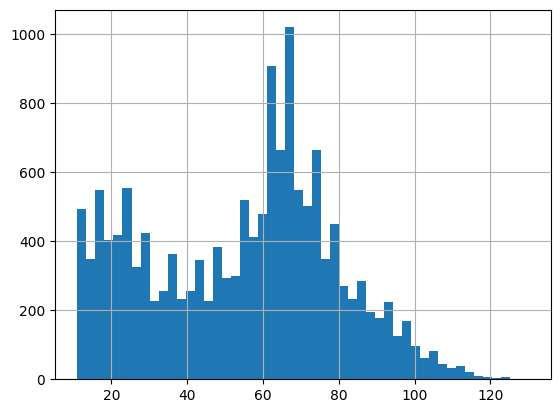

In [64]:
df.Word_Count.hist(bins=50)

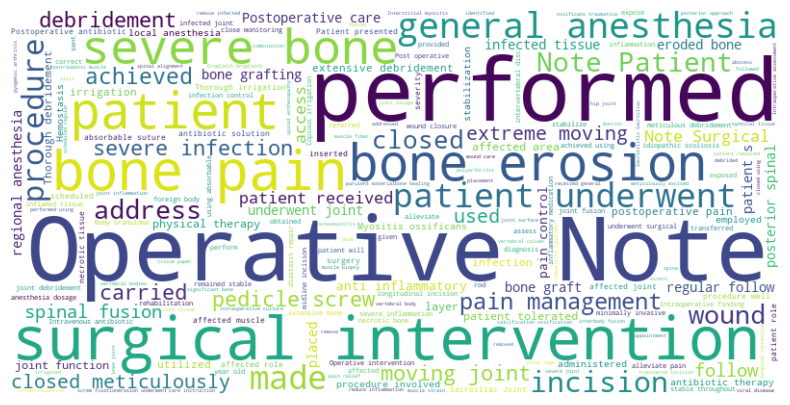

In [67]:
from wordcloud import WordCloud

# Example text dataset
text = ' '.join(df['notes'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

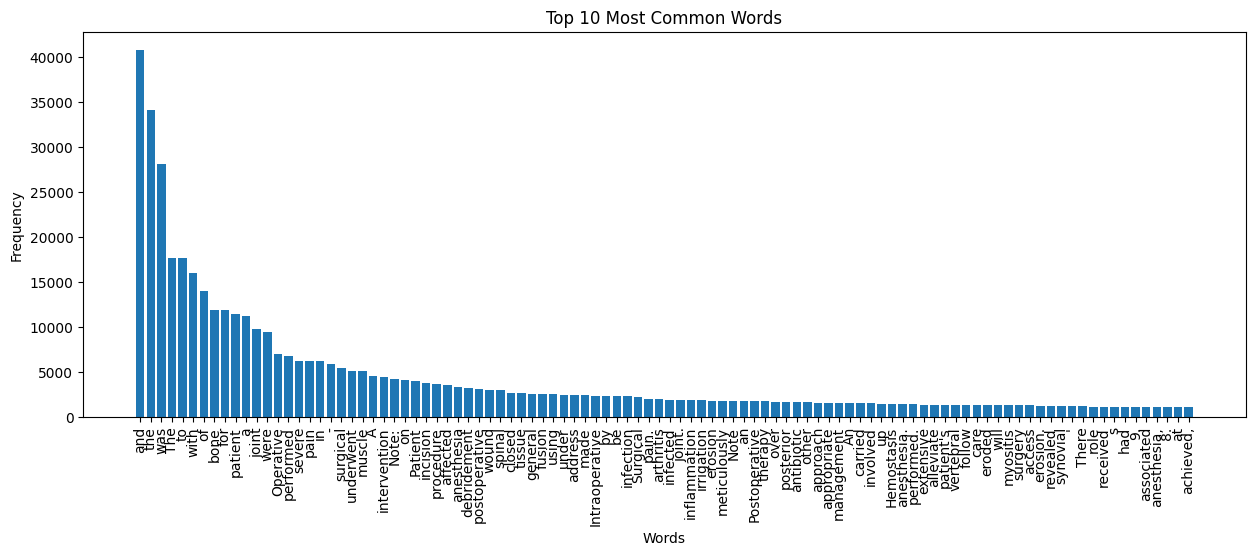

In [71]:
from collections import Counter

# Concatenate all text entries into a single string
text = ' '.join(df['notes'])

# Tokenize the text into individual words
tokens = text.split()

# Count the frequency of each word
word_counts = Counter(tokens)

# Get the most common words and their frequencies
top_words = word_counts.most_common(100)  # Change the number to display more or fewer words

# Extract the words and frequencies
words, frequencies = zip(*top_words)

# Create a bar plot
plt.figure(figsize=(15, 5))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=90)
plt.show()

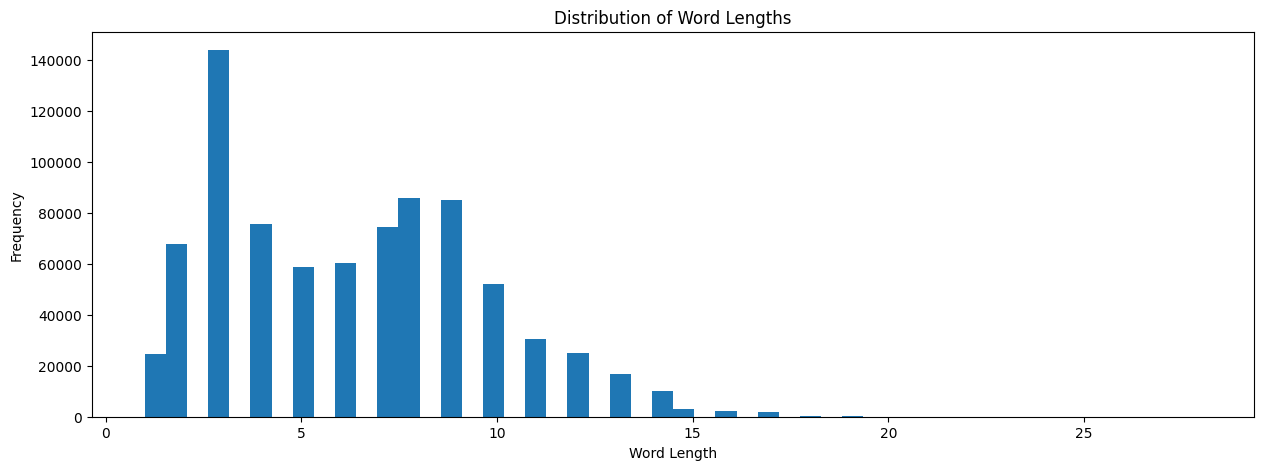

In [73]:
# Concatenate all text entries into a single string
text = ' '.join(df['notes'])

# Tokenize the text into individual words
tokens = text.split()

# Calculate the length of each word
word_lengths = [len(word) for word in tokens]

# Create a histogram
plt.figure(figsize=(15, 5))
plt.hist(word_lengths, bins=50)
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths')
plt.show()

In [75]:
import pyLDAvis.gensim_models
from gensim import models
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import nltk

# Concatenate all text entries into a single string
text = ' '.join(df['notes'])

# Tokenize the text into individual words
tokens = nltk.word_tokenize(text)

# Create a Gensim Dictionary
dictionary = Dictionary([tokens])

# Create a Gensim Corpus
corpus = [dictionary.doc2bow(tokens)]

# Define the number of topics for LDA
num_topics = 10

# Create and fit the LDA model
lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

# Visualize the topics
vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


# Model Engineering

## Data Spliting

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

In [82]:
size = int(len(df)*0.9)
train = df[:size]
test = df[size:]

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), 
                             max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)

tfIdfMat  = vectorizer.fit_transform(df['notes'].tolist())
feature_names = sorted(vectorizer.get_feature_names_out())



pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = df['codes'].tolist()
category_list = df.codes.unique()



X_temp, X_test, y_temp, y_test = train_test_split(tfIdfMat_reduced, labels, 
                                                    test_size=0.2, stratify=labels,random_state=1)
   
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=23)

print(X_train.shape, X_val.shape, X_test.shape)

(8992, 580) (2998, 580) (2998, 580)


In [81]:
print(f"Feature names or Tokens: {feature_names}")
print(f"Data shape{tfIdfMat.shape}")

Feature names or Tokens: ['10', '10 operative', '10 operative note', '10 patient', '800', '888', 'abscess', 'abscess evacuation', 'absorbable', 'absorbable sutures', 'access', 'access affected', 'accessed', 'achieve', 'achieved', 'achieved using', 'achieved wound', 'achieved wound closed', 'additional', 'address', 'address bone', 'address severe', 'address severe bone', 'addressed', 'adequate', 'adjusted', 'administered', 'advanced', 'advised', 'affected', 'affected area', 'affected joint', 'affected muscle', 'affected role', 'affecting', 'agent', 'aimed', 'alignment', 'alleviate', 'alleviate pain', 'alleviate severe', 'allograft', 'allowing', 'anaesthesia', 'analgesics', 'analysis', 'anesthesia', 'anesthesia administered', 'anesthesia appropriate', 'anesthesia appropriate dosage', 'anesthesia care', 'anesthesia dosage', 'anesthesia intraoperative', 'anesthesia intravenous', 'anesthesia patient', 'anesthetic', 'ankle', 'ankle joint', 'anterior', 'anterior approach', 'anti', 'anti infla

## Logistic Regression

In [83]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', 
                         l1_ratio=0.5, max_iter=150, random_state=23).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

In [84]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

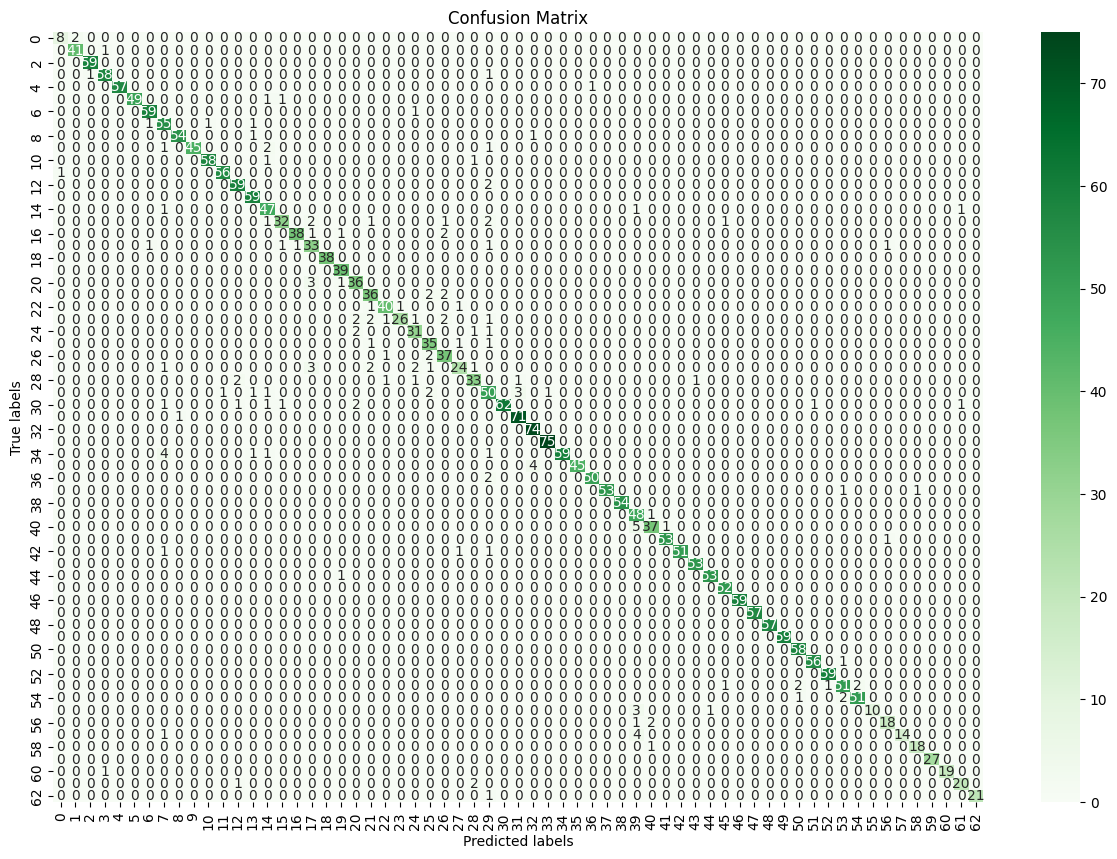

In [88]:
fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

ax.set_xticks(range(0,len(labels)))
ax.set_yticks(range(0,len(labels)))
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')  

plt.show()

In [89]:
print(classification_report(y_test,y_test_pred,labels=category_list))

              precision    recall  f1-score   support

       M01.4       1.00      0.92      0.96        49
       M41.4       0.83      0.92      0.88        38
       M40.0       0.91      0.80      0.85        40
       M61.2       0.98      1.00      0.99        53
       M62.6       0.98      1.00      0.99        59
       M40.3       1.00      1.00      1.00        38
       M41.9       0.87      0.85      0.86        39
       M40.5       0.86      0.90      0.88        40
       M60.2       1.00      1.00      1.00        54
         M45       0.77      0.85      0.81        59
       M02.1       0.85      0.94      0.90        50
       M60.1       1.00      0.96      0.98        55
       M65.3       1.00      0.95      0.98        22
       M61.1       1.00      0.94      0.97        54
       M41.8       0.89      0.71      0.79        34
       M00.8       0.97      0.97      0.97        60
       M62.0       1.00      1.00      1.00        59
       M01.2       0.85    

In [90]:
clf.predict(X_val[:3]) == y_val[:3]

array([ True,  True,  True])

## Random Forest Classifier

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

In [93]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.9467300768378923


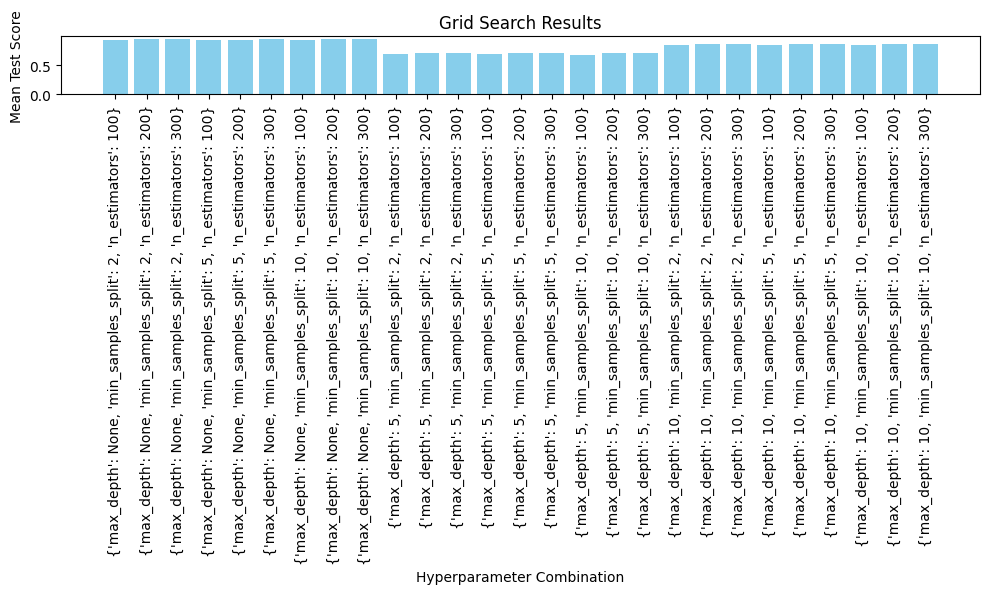

In [96]:
param_values = []
mean_scores = []
for params, mean_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    param_values.append(str(params))
    mean_scores.append(mean_score)

# Create a bar plot to visualize the mean scores for each hyperparameter combination
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(mean_scores)), mean_scores, align='center', color='skyblue')
plt.xticks(np.arange(len(mean_scores)), param_values, rotation=90)
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results')
plt.tight_layout()
plt.show()

In [97]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=None, min_samples_split=2, n_estimators=300)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
labels = category_list
cm_rf = confusion_matrix(y_test, y_test_pred)

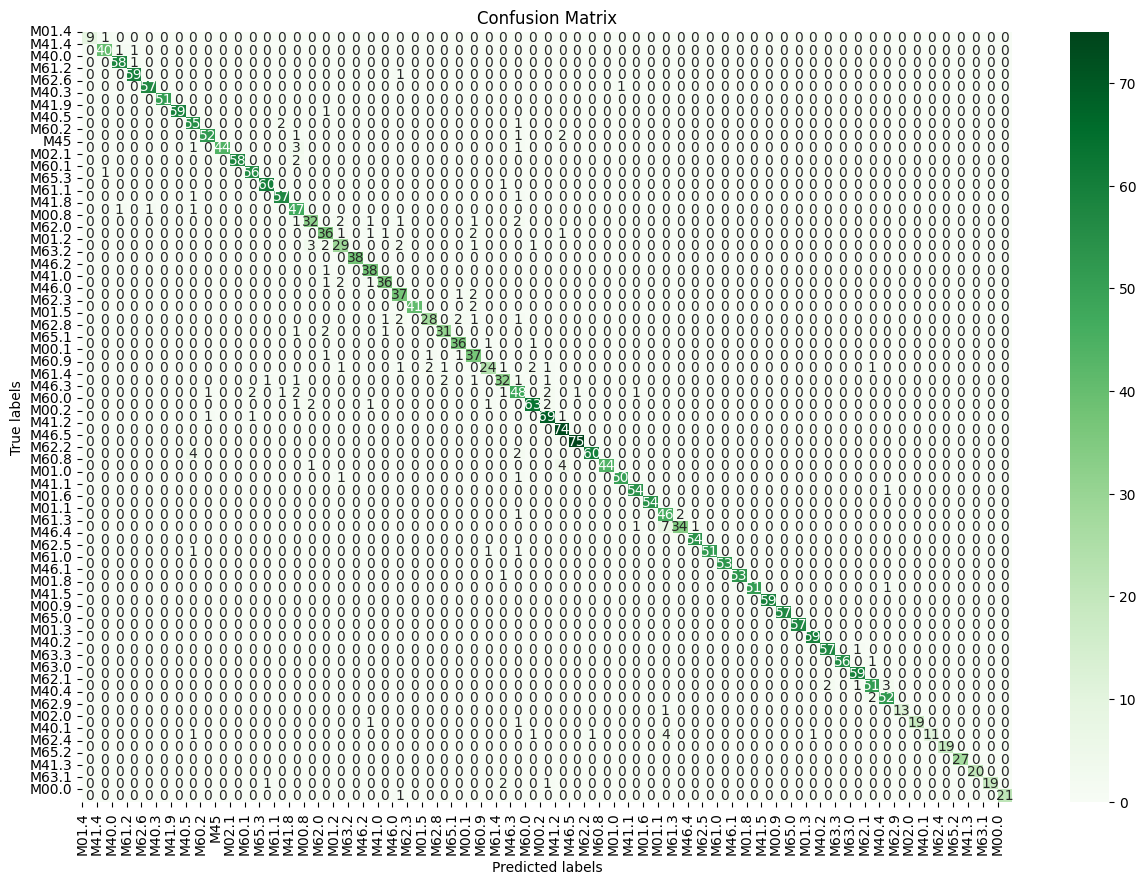

In [116]:
fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm_rf, annot=True, cmap="Greens",ax = ax,fmt='g') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.set_xticks(range(0,len(labels)))
ax.set_yticks(range(0,len(labels)))
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right')  
plt.show()

In [131]:
print(classification_report(y_test,y_test_pred,labels=category_list))

              precision    recall  f1-score   support

       M01.4       1.00      0.90      0.95        49
       M41.4       0.90      0.95      0.92        38
       M40.0       0.84      0.80      0.82        40
       M61.2       1.00      1.00      1.00        53
       M62.6       0.97      1.00      0.98        59
       M40.3       1.00      1.00      1.00        38
       M41.9       0.84      0.82      0.83        39
       M40.5       0.92      0.90      0.91        40
       M60.2       1.00      1.00      1.00        54
         M45       0.77      0.81      0.79        59
       M02.1       0.80      0.94      0.86        50
       M60.1       0.96      0.98      0.97        55
       M65.3       1.00      0.95      0.98        22
       M61.1       1.00      0.94      0.97        54
       M41.8       0.89      0.71      0.79        34
       M00.8       0.97      0.98      0.98        60
       M62.0       1.00      1.00      1.00        59
       M01.2       0.86    

In [118]:
rf.predict(X_val[100:103]) == y_val[100:103]

array([ True,  True,  True])